In [17]:
import math
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy import stats
from scipy import signal
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.odr import ODR, Model, Data, RealData
from pylab import *
from openpyxl import Workbook

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker

import os

In [18]:
data = pd.read_excel(r"C:\Users\matth\Documents\Phys 382\Lock-In data\EPR Lock-In Data.xlsx",None)
MagResonances = []
FreqResonances = []

In [19]:
def guassDerivative(x,a,b,c,d): # Where a is the height of a guass peak, b is the centre position and c is the s.d.
      return (a*(x-b)*(math.e)**((-((b-x)**2))/(2*c**2)))/(c**2) + d

In [20]:
def lorentzDerivative(x,a,b,c,d):
    return - (a * (1/math.pi) * c * (x-b)) / (((x-b)**2+0.25*c**2)**2) + d

In [21]:
def Linear(x,m,c):
    return m*x+c

[5.246530407709433, 1.220355, 0.3443312896186223, 0]
[5.79198586 1.22205343 0.4072527  6.28606434]
[7.234728109673251, 1.461465, 0.3736360802244622, 0]
[6.69610158 1.45684725 0.40904044 9.73381221]
[6.796544102052926, 1.71738, 0.36630988257300223, 0]
[6.51840865 1.71192806 0.40938509 8.97497483]
[6.283692394749012, 1.97118, 0.36630988257300223, 0]
[5.47826259 1.96873204 0.39636667 8.9311002 ]
[5.567854079163652, 2.172105, 0.40294087083030244, 0]
[4.28115651 2.17953462 0.42239223 7.52102715]
[9.463334901971765, 2.480895, 0.3882884755273825, 0]
[10.63313952  2.47931133  0.43745207  4.66467443]
[17.30791877558851, 2.7346950000000003, 0.4322456614361423, 0]
[16.55770396  2.72945744  0.44334949  5.20117102]
[19.681419349819734, 3.0117599999999998, 0.4395718590876019, 0]
[19.10844982  3.00390352  0.45998877  7.42805225]
[18.440805695307287, 3.2380649999999997, 0.4175932661332231, 0]
[20.08706755  3.24363725  0.46879868  9.66122257]
[21.712427709500034, 3.534165, 0.446898056739063, 0]
[21.388

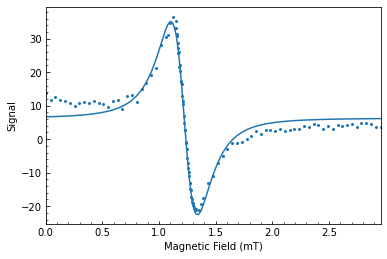

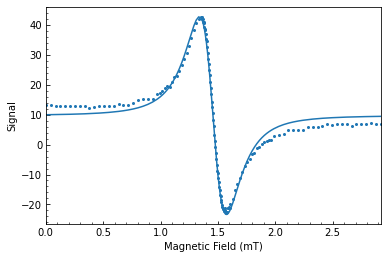

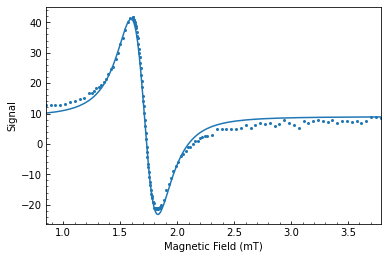

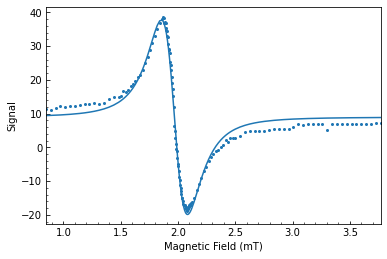

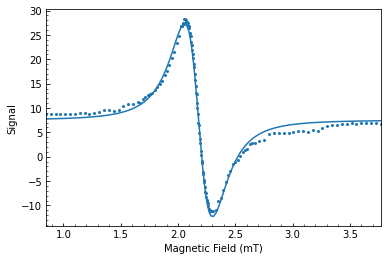

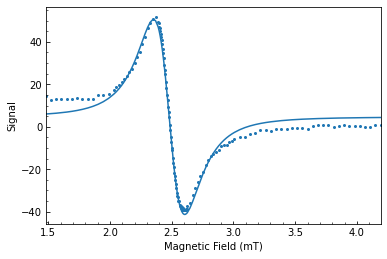

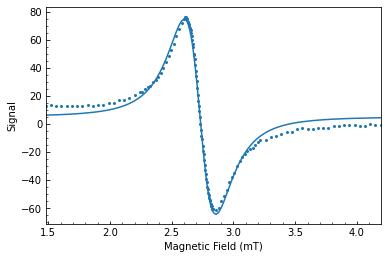

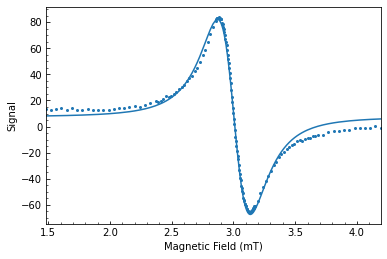

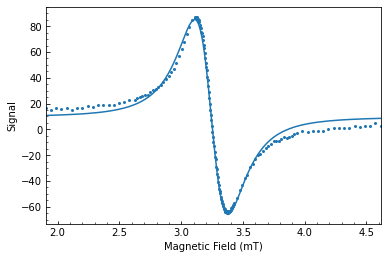

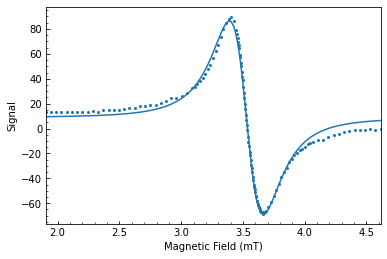

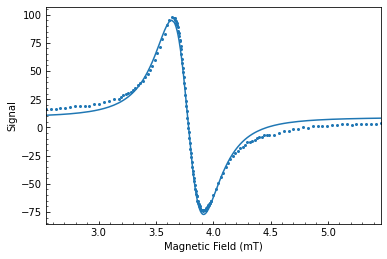

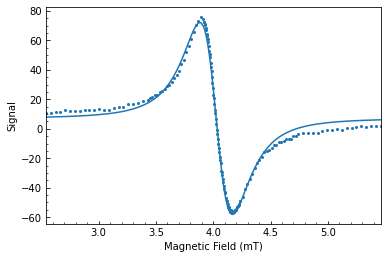

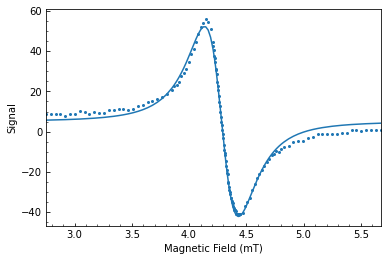

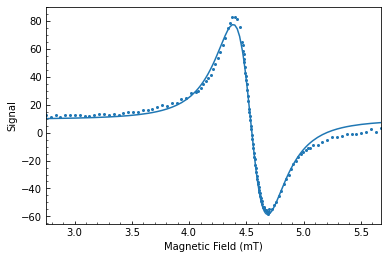

In [43]:
MagResonances = []
FreqResonances = []
threeDData = []
widths = []
amplitudes = []
yOffsets = []
for i, sheet in enumerate(data):


        
        if "test" not in sheet.lower():
            AmpData = (data[sheet]["Amplitude"]).to_numpy()
            MagneticData = (data[sheet]["MagField"]).to_numpy()  

            maxLoc = MagneticData[np.argmax(AmpData)]
            minLoc = MagneticData[np.argmin(AmpData)]
            centre = (minLoc-maxLoc)/2 + maxLoc

            guessGuass =[-(np.max(AmpData)/0.60653)*minLoc-maxLoc,centre, ((minLoc-maxLoc)/2),0]
            guessLorentz = [((np.max(AmpData))*(((minLoc-maxLoc)/2)/0.28869)**2)/0.826,centre, ((minLoc-maxLoc)/2)/0.28869,0]

            print(guessLorentz)

            funcUsed = lorentzDerivative

            popt, pcov = scipy.optimize.curve_fit(funcUsed, MagneticData, AmpData, p0=guessLorentz) 

            print(popt)

            Amp, Loc, SDev,d = popt

            AmpErr,LocErr,SDevErr,dErr = sqrt(diag(pcov))

            widths.append(SDev)
            amplitudes.append(Amp)
            yOffsets.append(d)
            AmpGuess,LocGuess,SDevGuess,d2 = guessLorentz
            signalData = funcUsed(MagneticData,Amp,Loc,SDev,d)
            fig, ax = plt.subplots() 
            ax.plot(MagneticData,signalData)
            ax.scatter(MagneticData,AmpData,s=4)
            ax.set_xlabel("Magnetic Field (mT)")
            ax.set_ylabel("Signal")
            ax.set_xlim(left=MagneticData[0],right = MagneticData[-1])
            ax.tick_params(which='both',direction = 'in')
            ax.minorticks_on()

            plt.savefig(os.path.join(r"C:\Users\matth\Documents\Phys 382\Lock-In data\Finalised Plots",str(int(float(sheet)*1000)))+".jpg")

            #figData = "Metadata:\n\nAmp: {}±{} \nX offset: {}±{}\nWidth/SDev: {}±{}\nY offset: {}±{}".format(Amp,AmpErr,Loc,LocErr,SDev,SDevErr,d,dErr)
            #f = open(os.path.join(r"C:\Users\matth\Documents\Phys 382\Lock-In data\Finalised Plots",str(int(float(sheet)*1000)))+".txt",'x')
            #f.write(figData)
            #f.close()
            #plt.show()

            while (MagneticData[-1]<5.6):
                  MagneticData = np.append(MagneticData,(2*MagneticData[-1]-MagneticData[-2]))
                  AmpData = np.append(AmpData,(np.average(AmpData[-5:-1])))
            while (MagneticData[0]>0):
                  MagneticData = np.insert(MagneticData,0,(2*MagneticData[0]-MagneticData[1]))
                  AmpData = np.insert(AmpData,0,(np.average(AmpData[0:4])))


            for magRes,Ampls in zip(MagneticData,AmpData):
                  threeDData.append([magRes,float(sheet),Ampls])
            #plt.xticks(np.linspace(np.min(MagneticData),np.max(MagneticData),10))
            #plt.yticks(np.linspace(np.min(signalData),np.max(signalData),10))


          

            #MagResonances.append((minLoc-maxLoc)/2 + maxLoc)
            MagResonances.append(Loc)
            FreqResonances.append(float(sheet))

            





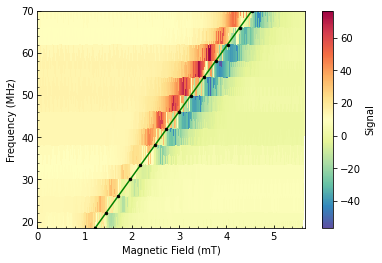

In [40]:
# 3D code Plot




xData = []
yData = []
zData = []
for element in threeDData:
    xData.append(element[0])
    yData.append(element[1])
    zData.append(element[2])

xData = np.array(xData)
yData = np.array(yData)
zData = np.array(zData)

plot1,ax = plt.subplots()

guessLinear = [12,0]

popt, pcov = scipy.optimize.curve_fit(Linear, MagResonances, FreqResonances, p0=guessLinear)

grad,yInt = popt

gradU,yIntU = sqrt(diag(pcov))

cmaps = ax.tripcolor(xData,yData,zData,cmap="Spectral_r",zorder = 1)
plot1.colorbar(cmaps,label = "Signal")
ax.set_xlabel("Magnetic Field (mT)")
ax.set_ylabel("Frequency (MHz)")
ax.minorticks_on()
ax.plot(MagResonances,grad*np.array(MagResonances)+yInt,zorder = 2,c="green")
ax.set_xlim(np.min(xData),np.max(xData))
ax.set_ylim(np.min(yData),np.max(yData))
ax.tick_params(which="both",direction= "in")

ax.scatter(MagResonances,FreqResonances,s=6,c='black',zorder = 3)
plt.show()

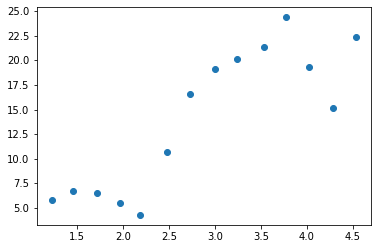

In [42]:
# Amplitude Plots

plot2,ax2 = plt.subplots()

ax2.scatter(MagResonances,yOffsets)
ax2.set_xlabel("Magnetic Field")
ax2
plt.show()